In [1]:
using Pkg
Pkg.activate("..")
#Pkg.instantiate()

"/machome/gits/StatisticalProcesses/Project.toml"

In [51]:
using Revise
using StatisticalProcesses
using Distributions
using Plots
using LinearAlgebra
using Optim
gr()

Plots.GRBackend()

(xn, yn) = (1.904695138012177, -1.7557029427658828)
(xbest, ybest) = (-0.6709080788055934, -0.015824495840945196)
(xn, yn) = (0.44375673551161987, -0.8577408336976085)
(xbest, ybest) = (-0.6709080788055934, -0.015824495840945196)
(xn, yn) = (-0.9999999999999999, -1.558879991940132)
(xbest, ybest) = (-0.6709080788055934, -0.015824495840945196)
(xn, yn) = (-0.4299331476654206, 0.4749837515228919)
(xbest, ybest) = (-0.4299331476654206, 0.4749837515228919)
(xn, yn) = (1.1253556499687214, -0.24634468494882467)
(xbest, ybest) = (-0.4299331476654206, 0.4749837515228919)
(xn, yn) = (-0.1837202744020506, 0.3613191754863937)
(xbest, ybest) = (-0.4299331476654206, 0.4749837515228919)
(xn, yn) = (-0.35717427285262565, 0.5003351767900897)
(xbest, ybest) = (-0.35717427285262565, 0.5003351767900897)
(xn, yn) = (-0.34337678558264184, 0.4990947252299074)
(xbest, ybest) = (-0.35717427285262565, 0.5003351767900897)
(xn, yn) = (0.8429305764599351, -0.6956415351629904)
(xbest, ybest) = (-0.3571742728526256

┌ Warning: Linesearch failed, using alpha = 0.6932828043709054 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /opt/julia/share/site/packages/Optim/Agd3B/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 8.560360631622459 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /opt/julia/share/site/packages/Optim/Agd3B/src/utilities/perform_linesearch.jl:47


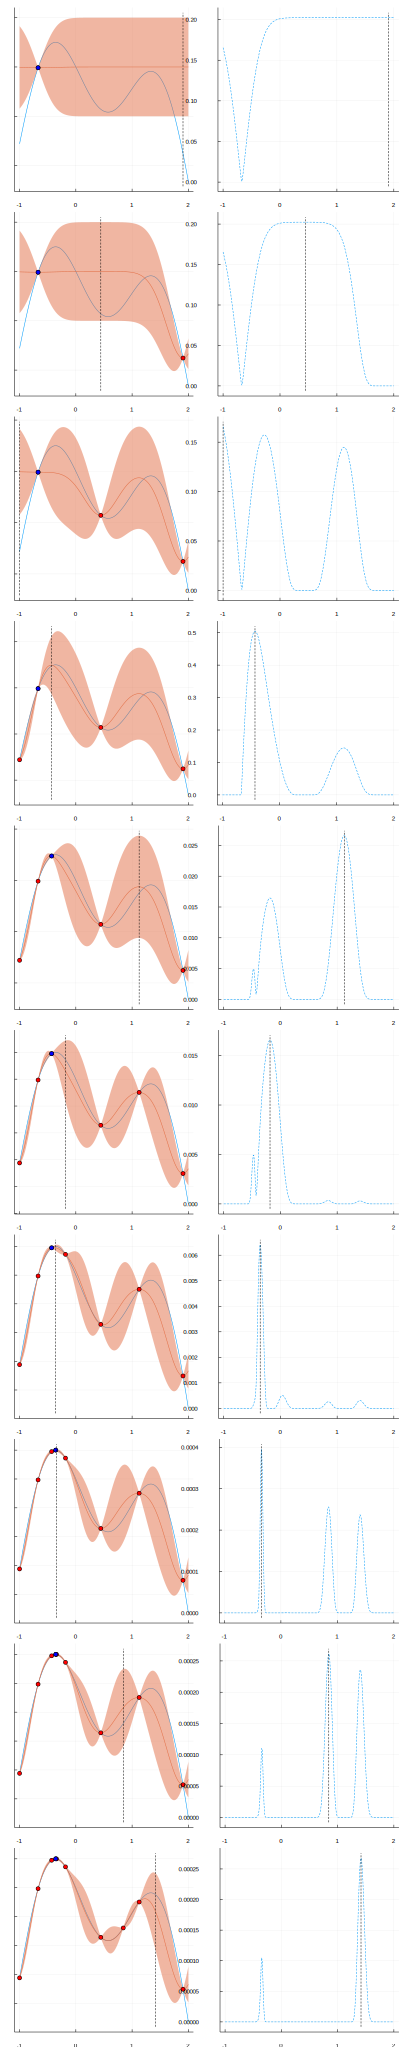

In [200]:
f(x) = -sin(3x) - x^2 + 0.7*x

k(x, xp; σ, δ) = δ^2 * exp(-norm(x-xp)^2/(2σ^2))

a = -1.
b = 2.0
u = Uniform(a,b)

x = [rand(u)]
y = f.(x)
ybest = y[1]
xbest = x[1]

hypers = (δ=0.5, σ=0.3, σn=0.01)
xx = collect(a:0.01:b)
yy = f.(xx)
gp = nothing

ps = []

function a_EI(gp, x, fbest; ξ=0.01)
    n = Normal()
    ϕ(x) = pdf(n, x)
    Φ(x) = cdf(n, x)

    μ, σ = mean(gp, x), std(gp, x)    
    imp = μ - fbest - ξ
    Z = imp/σ
    return imp*Φ(Z) + σ*ϕ(Z)
end

nstep = 10
nrestart = 100

for i=1:nstep
    gp = GP(x, y, k; hypers...)
    #hypers, L, gp = optimize_hypers(gp, upper=[10.0, 10.0, 10.0], laplace=false)  
    
    xns = []
    yns = []
    for i=1:nrestart
        x0 = rand(u)
        optfunc = OnceDifferentiable(X -> -a_EI(gp, X[1], ybest), 
                                    [x0]; autodiff=:forward)
        res = optimize(optfunc, [a], [b], [x0], Fminbox())
        push!(xns, res.minimizer[1])
        push!(yns, res.minimum)
    end
        
    _, ibest = findmin(yns)
    xn = xns[ibest]
    yn = f(xn)
    
    p1 = plot(xx, yy, legend=false)
    plot!(xx, gp(xx), ribbon=2*std(gp, xx))
    scatter!(x, y, color=:red)
    scatter!([xbest], [ybest], color=:blue)
    plot!([xn, xn], collect(ylims()), linestyle=:dash, color=:black)    
    push!(ps, p1)    
    
    aa = a_EI.(gp, xx, ybest)
    p2 = plot(xx, aa, linestyle=:dash, legend=false)
    plot!([xn, xn], collect(ylims()), linestyle=:dash, color=:black)
    push!(ps, p2)
    
    @show xn, yn
        
    if yn > ybest 
        ybest = yn
        xbest = xn
    end
    
    @show xbest, ybest
        
    x = [x; xn]
    y = [y; yn]
end

plot(ps..., layout=(length(ps)÷2, 2), size=(800, 200*length(ps)))